In [2]:
import pandas as pd

# 전처리 CSV 파일 불러오기 
df = pd.read_csv('wildfire_preprocessed_final.csv')

# 데이터 첫 5행 확인
print(df.head())

   DSPT_REQ_HR  FIRE_SUPESN_HR  CTPV_NM  SGG_NM  FRSTN_GRNDS_DSTNC  \
0          246            1200        8      66                 11   
1          253             600        8      66                  4   
2          643            1457        8      66                  9   
3          578            1529        4      62                  5   
4          874           14464        0      16                 26   

   CNTR_GRNDS_DSTNC  LFDAU_GRNDS_DSTNC  FCLT_PLC_SCLSF_NM  FND_FIRE_SE_NM  \
0                 4               -1.0                  1               1   
1                 2               -1.0                  0               0   
2                 5               -1.0                  1               1   
3                 2               -1.0                  1               1   
4                10               -1.0                  2               2   

   FND_IGTN_PSTN_NM  HR_UNIT_ARTMP  HR_UNIT_WSPD_INFO  WNDRCT_BRNG  \
0                 1           -1.0            

In [3]:
df.head()

,DSPT_REQ_HR,FIRE_SUPESN_HR,CTPV_NM,SGG_NM,FRSTN_GRNDS_DSTNC,CNTR_GRNDS_DSTNC,LFDAU_GRNDS_DSTNC,FCLT_PLC_SCLSF_NM,FND_FIRE_SE_NM,FND_IGTN_PSTN_NM,HR_UNIT_ARTMP,HR_UNIT_WSPD_INFO,WNDRCT_BRNG,HR_UNIT_HUM,golden_time_under_50min,arrival_time_diff,is_night,month_rcpt,dispatch_time_diff
0,246,1200,8,66,11,4,-1.0,1,1,1,-1.0,2.0,7,39.0,1,337.0,1,1,91.0
1,253,600,8,66,4,2,-1.0,0,0,1,5.0,2.0,3,60.0,1,291.0,1,3,38.0
2,643,1457,8,66,9,5,-1.0,1,1,1,7.0,2.0,3,49.0,1,676.0,1,3,33.0
3,578,1529,4,62,5,2,-1.0,1,1,3,0.3,10.5,7,48.0,1,636.0,0,3,58.0
4,874,14464,0,16,26,10,-1.0,2,2,4,-8.7,20.0,8,36.0,1,906.0,1,12,32.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [5]:
# 파일 경로
CSV_PATH = "wildfire_preprocessed_final.csv"

# 예측 시점 선택에 따라 누수 변수 포함/제외 토글
# True  -> 도착 이후 시점(허용),  ARRIVAL_DELAY_MIN_LOG 포함
# False -> 발생 직후 시점(비허용), ARRIVAL_DELAY_MIN_LOG 제외
INCLUDE_LEAKY = True

# 데이터 로드
df = pd.read_csv(CSV_PATH)

print(f"행: {len(df):,}, 열: {len(df.columns)}")
print("\n컬럼명:\n", df.columns.tolist()[:50], " ...")
display(df.head())

# 타깃/피처 선택
TARGET = "FIRE_SUPESN_HR"
if TARGET not in df.columns:
    raise ValueError(f"'{TARGET}' 컬럼이 없습니다.")

# 숫자형 컬럼만 사용(원-핫 완료 가정)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET]

# 필요 시 누수 변수 제거
if not INCLUDE_LEAKY and "ARRIVAL_DELAY_MIN_LOG" in feature_cols:
    feature_cols.remove("ARRIVAL_DELAY_MIN_LOG")

X = df[feature_cols].copy()
y = df[TARGET].copy()

# 결측치 처리(있으면 행 제거)
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\n최종 데이터 크기: X={X.shape}, y={y.shape}")
print(f"누수 변수 포함 여부(INCLUDE_LEAKY) = {INCLUDE_LEAKY}")


행: 3,560, 열: 19

컬럼명:
 ['DSPT_REQ_HR', 'FIRE_SUPESN_HR', 'CTPV_NM', 'SGG_NM', 'FRSTN_GRNDS_DSTNC', 'CNTR_GRNDS_DSTNC', 'LFDAU_GRNDS_DSTNC', 'FCLT_PLC_SCLSF_NM', 'FND_FIRE_SE_NM', 'FND_IGTN_PSTN_NM', 'HR_UNIT_ARTMP', 'HR_UNIT_WSPD_INFO', 'WNDRCT_BRNG', 'HR_UNIT_HUM', 'golden_time_under_50min', 'arrival_time_diff', 'is_night', 'month_rcpt', 'dispatch_time_diff']  ...


,DSPT_REQ_HR,FIRE_SUPESN_HR,CTPV_NM,SGG_NM,FRSTN_GRNDS_DSTNC,CNTR_GRNDS_DSTNC,LFDAU_GRNDS_DSTNC,FCLT_PLC_SCLSF_NM,FND_FIRE_SE_NM,FND_IGTN_PSTN_NM,HR_UNIT_ARTMP,HR_UNIT_WSPD_INFO,WNDRCT_BRNG,HR_UNIT_HUM,golden_time_under_50min,arrival_time_diff,is_night,month_rcpt,dispatch_time_diff
0,246,1200,8,66,11,4,-1.0,1,1,1,-1.0,2.0,7,39.0,1,337.0,1,1,91.0
1,253,600,8,66,4,2,-1.0,0,0,1,5.0,2.0,3,60.0,1,291.0,1,3,38.0
2,643,1457,8,66,9,5,-1.0,1,1,1,7.0,2.0,3,49.0,1,676.0,1,3,33.0
3,578,1529,4,62,5,2,-1.0,1,1,3,0.3,10.5,7,48.0,1,636.0,0,3,58.0
4,874,14464,0,16,26,10,-1.0,2,2,4,-8.7,20.0,8,36.0,1,906.0,1,12,32.0



최종 데이터 크기: X=(3560, 18), y=(3560,)
누수 변수 포함 여부(INCLUDE_LEAKY) = True


In [6]:
def optimize_hyperparameters(X, y):
    """
    RandomForest 하이퍼파라미터 그리드 탐색 (5-fold, MSE 기준)
    ※ 회귀에서 'auto'는 비권장/오류 → ['sqrt','log2']만 사용
    """
    print("=== 1단계: 하이퍼파라미터 최적화 시작 ===")
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    param_grid = {
        'n_estimators': [100, 200, 400],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
    }

    gscv = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',  # RMSE를 바로 쓰려면 'neg_root_mean_squared_error'도 가능
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    gscv.fit(X, y)

    best_params = gscv.best_params_
    best_score_mse = -gscv.best_score_

    print(f"\n최적 하이퍼파라미터: {best_params}")
    print(f"최적 CV MSE: {best_score_mse:,.4f} (RMSE={np.sqrt(best_score_mse):,.4f})")

    return best_params, gscv.best_estimator_

best_params, best_model = optimize_hyperparameters(X, y)


=== 1단계: 하이퍼파라미터 최적화 시작 ===
Fitting 5 folds for each of 216 candidates, totalling 1080 fits



최적 하이퍼파라미터: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}
최적 CV MSE: 117,421,903.5526 (RMSE=10,836.1388)


In [7]:
def train_multiple_models(X, y, best_params, n_iterations=10, k_folds=5):
    """
    최적 파라미터 고정 + seed만 바꿔가며 10회 k-fold CV
    RMSE/MAE/R² 평균·표준편차를 저장
    """
    print(f"\n=== 2단계: {n_iterations}회 학습(k={k_folds}) ===")
    results = []
    models = []

    for i in range(n_iterations):
        print(f"\n--- {i+1}번째 모델 학습 ---")
        rf = RandomForestRegressor(**best_params, random_state=42+i, n_jobs=-1)
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42+i)

        # MSE / R2 / MAE (sklearn은 neg_* 반환 → 부호 반전)
        mse_scores = -cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        rmse_scores = np.sqrt(mse_scores)
        r2_scores  = cross_val_score(rf, X, y, cv=kf, scoring='r2', n_jobs=-1)
        mae_scores = -cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)

        result = {
            'iteration': i+1,
            'mse_mean': mse_scores.mean(), 'mse_std': mse_scores.std(),
            'rmse_mean': rmse_scores.mean(), 'rmse_std': rmse_scores.std(),
            'r2_mean': r2_scores.mean(),     'r2_std': r2_scores.std(),
            'mae_mean': mae_scores.mean(),   'mae_std': mae_scores.std(),
            'mse_scores': mse_scores, 'rmse_scores': rmse_scores,
            'r2_scores': r2_scores,   'mae_scores': mae_scores
        }
        results.append(result)
        models.append(rf)

        print(f"  RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
        print(f"  MAE : {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
        print(f"  R²  : {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    return results, models

results, models = train_multiple_models(X, y, best_params, n_iterations=10, k_folds=5)



=== 2단계: 10회 학습(k=5) ===

--- 1번째 모델 학습 ---
  RMSE: 10736.2953 ± 1274.8897
  MAE : 5596.0258 ± 340.0159
  R²  : 0.0463 ± 0.0053

--- 2번째 모델 학습 ---
  RMSE: 10740.8076 ± 754.9745
  MAE : 5605.7525 ± 243.0214
  R²  : 0.0589 ± 0.0269

--- 3번째 모델 학습 ---
  RMSE: 10757.2789 ± 814.5674
  MAE : 5576.3754 ± 174.0867
  R²  : 0.0532 ± 0.0246

--- 4번째 모델 학습 ---
  RMSE: 10757.8039 ± 794.1460
  MAE : 5615.8711 ± 278.3360
  R²  : 0.0534 ± 0.0201

--- 5번째 모델 학습 ---
  RMSE: 10748.7222 ± 783.8621
  MAE : 5584.0553 ± 254.1576
  R²  : 0.0549 ± 0.0042

--- 6번째 모델 학습 ---
  RMSE: 10736.6757 ± 434.7084
  MAE : 5573.3549 ± 122.0242
  R²  : 0.0607 ± 0.0180

--- 7번째 모델 학습 ---
  RMSE: 10742.8738 ± 575.1941
  MAE : 5577.2694 ± 239.3489
  R²  : 0.0577 ± 0.0148

--- 8번째 모델 학습 ---
  RMSE: 10657.5876 ± 1264.7466
  MAE : 5562.7465 ± 369.6346
  R²  : 0.0615 ± 0.0184

--- 9번째 모델 학습 ---
  RMSE: 10777.1849 ± 458.4489
  MAE : 5607.5010 ± 116.1797
  R²  : 0.0533 ± 0.0044

--- 10번째 모델 학습 ---
  RMSE: 10714.9237 ± 1203.7502
  M


=== 3단계: 결과 종합 및 분석 ===

전체 10개 모델 성능 요약:
RMSE 평균: 10737.0153 ± 30.7239
MAE  평균: 5586.3172 ± 17.8658
R²   평균: 0.0550 ± 0.0045

최고 R² 모델: 8번째 (R²=0.0615)
최저 MSE 모델: 8번째 (MSE=115183756.6603, RMSE=10732.3696)


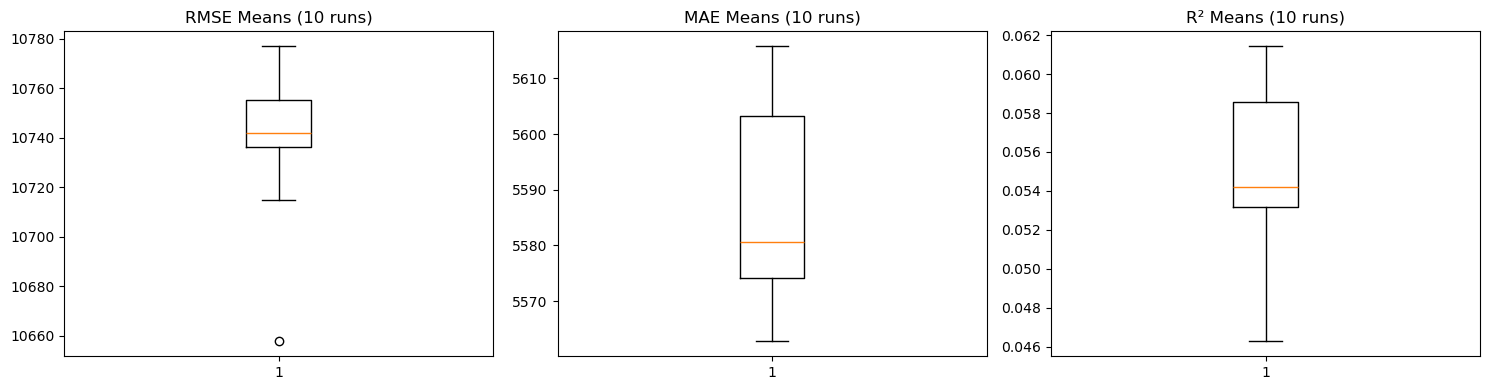

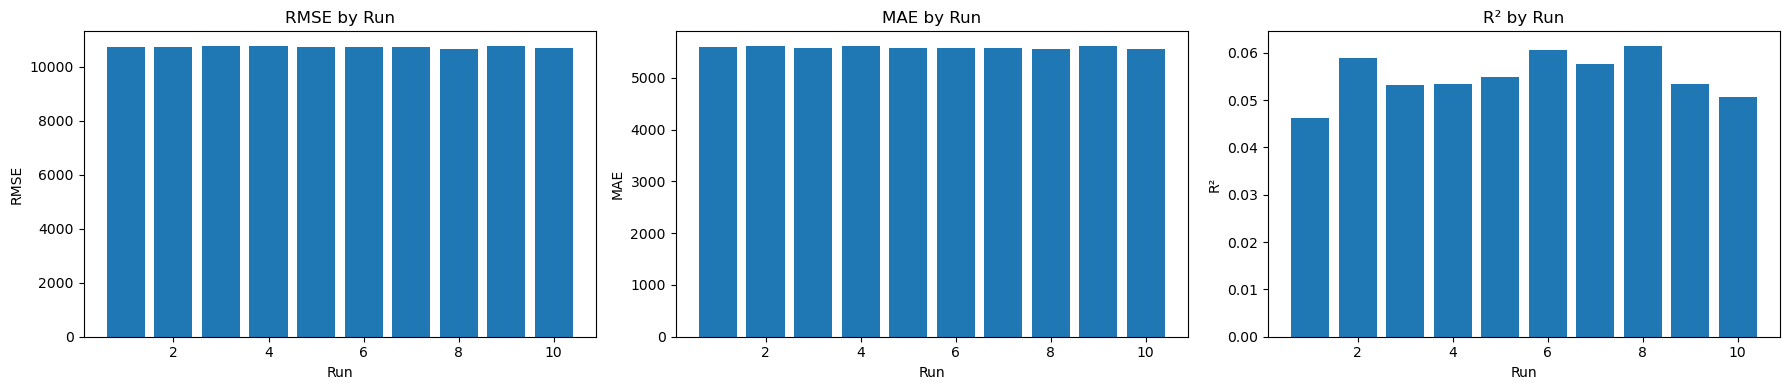


성능 지표 간 상관계수:
          MSE    RMSE     MAE      R2
MSE   1.0000  0.6039  0.5215 -0.9447
RMSE  0.6039  1.0000  0.6587 -0.3777
MAE   0.5215  0.6587  1.0000 -0.2833
R2   -0.9447 -0.3777 -0.2833  1.0000


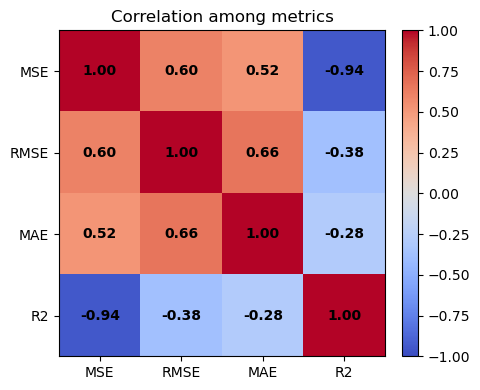

In [8]:
def analyze_results(results):
    print("\n=== 3단계: 결과 종합 및 분석 ===")
    rmse_means = [r['rmse_mean'] for r in results]
    mae_means  = [r['mae_mean']  for r in results]
    r2_means   = [r['r2_mean']   for r in results]
    mse_means  = [r['mse_mean']  for r in results]

    print(f"\n전체 {len(results)}개 모델 성능 요약:")
    print(f"RMSE 평균: {np.mean(rmse_means):.4f} ± {np.std(rmse_means):.4f}")
    print(f"MAE  평균: {np.mean(mae_means):.4f} ± {np.std(mae_means):.4f}")
    print(f"R²   평균: {np.mean(r2_means):.4f} ± {np.std(r2_means):.4f}")

    best_r2_idx  = int(np.argmax(r2_means))
    best_mse_idx = int(np.argmin(mse_means))
    print(f"\n최고 R² 모델: {best_r2_idx+1}번째 (R²={r2_means[best_r2_idx]:.4f})")
    print(f"최저 MSE 모델: {best_mse_idx+1}번째 (MSE={mse_means[best_mse_idx]:.4f}, RMSE={np.sqrt(mse_means[best_mse_idx]):.4f})")

    # --- Boxplot (분포)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].boxplot(rmse_means); axes[0].set_title('RMSE Means (10 runs)')
    axes[1].boxplot(mae_means);  axes[1].set_title('MAE Means (10 runs)')
    axes[2].boxplot(r2_means);   axes[2].set_title('R² Means (10 runs)')
    plt.tight_layout(); plt.show()

    # --- Bar plot (비교)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].bar(range(1, len(results)+1), rmse_means); axes[0].set_title('RMSE by Run'); axes[0].set_xlabel('Run'); axes[0].set_ylabel('RMSE')
    axes[1].bar(range(1, len(results)+1), mae_means);  axes[1].set_title('MAE by Run');  axes[1].set_xlabel('Run'); axes[1].set_ylabel('MAE')
    axes[2].bar(range(1, len(results)+1), r2_means);   axes[2].set_title('R² by Run');   axes[2].set_xlabel('Run'); axes[2].set_ylabel('R²')
    plt.tight_layout(); plt.show()

    # --- 상관행렬
    corr_df = pd.DataFrame({
        'MSE': mse_means, 'RMSE': rmse_means, 'MAE': mae_means, 'R2': r2_means
    })
    corr = corr_df.corr()
    print("\n성능 지표 간 상관계수:\n", corr.round(4))

    plt.figure(figsize=(5,4))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', color='black', fontweight='bold')
    plt.title('Correlation among metrics')
    plt.tight_layout(); plt.show()

    return best_r2_idx, best_mse_idx

best_r2_idx, best_mse_idx = analyze_results(results)


In [9]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# OS별 한글 폰트 설정
if platform.system() == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
else:  # Linux (예: Colab)
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지



=== 특성 중요도 분석 ===

상위 10개 특성 중요도:


,feature,importance
0,DSPT_REQ_HR,0.101460
14,arrival_time_diff,0.091604
9,HR_UNIT_ARTMP,0.089547
12,HR_UNIT_HUM,0.086919
17,dispatch_time_diff,0.085226
3,FRSTN_GRNDS_DSTNC,0.080530
1,CTPV_NM,0.075838
4,CNTR_GRNDS_DSTNC,0.073816
2,SGG_NM,0.072705
5,LFDAU_GRNDS_DSTNC,0.041848


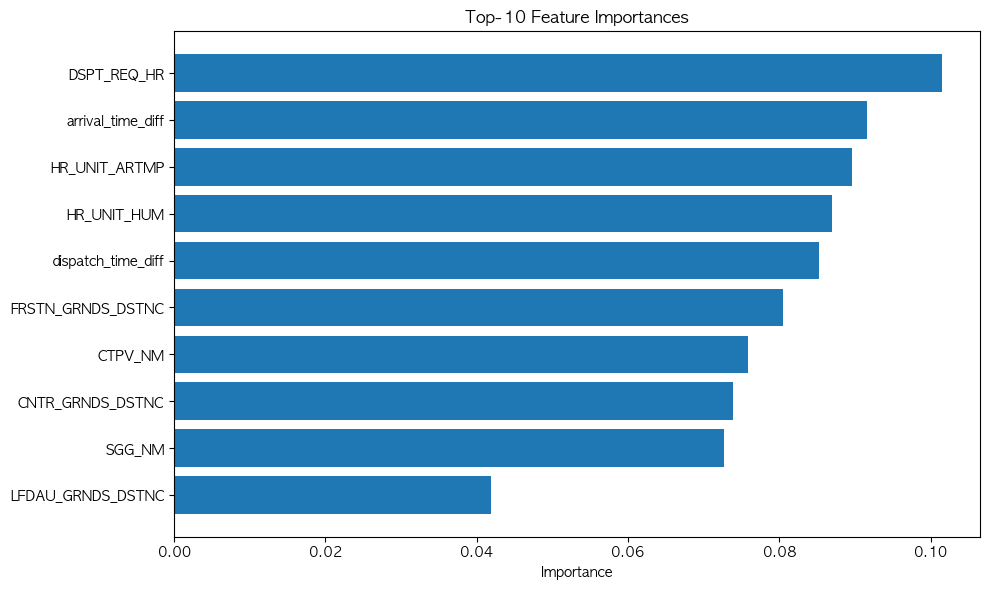

Exception ignored in: <function ResourceTracker.__del__ at 0x110b6dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102915bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10624dbc0>
Traceback (most recent call last

In [ ]:
print("\n=== 특성 중요도 분석 ===")
# 최적 모델(best_model)로 전체 데이터 적합 후 중요도 확인
best_model.fit(X, y)
fi = pd.DataFrame({'feature': feature_cols, 'importance': best_model.feature_importances_}) \
        .sort_values('importance', ascending=False)

print("\n상위 10개 특성 중요도:")
display(fi.head(10))

# 시각화
plt.figure(figsize=(10,6))
top = fi.head(10)
plt.barh(range(len(top)), top['importance'])
plt.yticks(range(len(top)), top['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Importance'); plt.title('Top-10 Feature Importances')
plt.tight_layout(); plt.show()


- 최적 하이퍼파라미터: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}